# Week 3 Capstone

Notebook for the third week of *Applied Data Science Capstone*.
This Notebook will contain segmenting and clustering neighborhoods in Toronto


## 1º Part: Web Scrapping the data set
Here we will be scraping a dataframe from a wikipedia table

In [1]:
!pip install bs4
!pip install geocoder
!pip install scikit-learn==0.23.1

     |████████████████████████████████| 122kB 11.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 102kB 17.1MB/s ta 0:00:01
     |████████████████████████████████| 6.9MB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 307kB 10.3MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1


In [2]:
import pandas as pd
import requests  # this module helps us to download a web page
from bs4 import BeautifulSoup # this module helps in web scrapping.

# Http url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
# Get Request
data = requests.get(url).text

In [4]:
# Create a SOUP
tables = BeautifulSoup(data, "html5lib").find_all('table') # in html table is represented by the tag <table>

In [5]:
# Define an array for the cells
procesedCellsArray = []
# Get all cells of the 1º table
cells = tables[0].findAll("td")
for i, cell in enumerate(cells): # For each cell
    if cell.span.text != "Not assigned": # If Borough/Neighborhood is asigned
        # Define Cell
        procesedCell = {}
        # Process Span for data
        spanText = cell.span.text.strip(')').replace(' / ', ', ').split('(')
        if(spanText[1] =="Not assigned"): # Neighborhood not defined
            spanText[1] = spanText[0]
        # Assing values
        procesedCell["PostalCode"] = cell.b.text
        procesedCell["Borough"] = spanText[0]
        procesedCell["Neighborhood"] = spanText[1]
        # Append cell
        procesedCellsArray.append(procesedCell)

# Convert to dataframe
df = pd.DataFrame(procesedCellsArray)
# Improve readability
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
# Get shape
df.shape

(103, 3)

In [7]:
# Get DataFrame head 10
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills)North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


## 2º Part: Geospatial Coordinates into dataset
Here we will be adding Geospatial Coordinates to the dataframe.
We will use the dataframe provided by the course because the api Calls take a long time.

In [8]:
import geocoder # import geocoder

# We define a function to get the Lat/Long for each postal code
def getLatLongByPostalCode(postalCode): 
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postalCode))
        lat_lng_coords = g.latlng
    # Return the values
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude, longitude

# We call de function to get the values
latitude = []
longitude = []
for index, row in df.iterrows(): # For each row
    lat, long = getLatLongByPostalCode(row["PostalCode"])
    latitude.append(lat)
    longitude.append(long)
# Append the new atributes to the dataframe
df["Latitude"] = latitude
df["Longitude"] = longitude

KeyboardInterrupt: 

In [9]:
# Alternatively, Merge dataframe with Geospatial Coordinates dataframe on Postal Code
dfLatLong = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")
dfCord = pd.merge(df, dfLatLong, left_on="PostalCode", right_on="Postal Code")
dfCord.drop("Postal Code", axis=1, inplace=True)

In [10]:
dfCord.shape

(103, 5)

In [11]:
dfCord.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills)North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## 3º Part: Clustering by K-Means
Now we have to cluster the Neighborhood by k-means using their latitude and longitude.
We will draw each Neighborhood by their cluster color.

In [137]:
# Some imports
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import silhouette_score as sc
from sklearn.preprocessing import MinMaxScaler

import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pylab import *

In [22]:
# Scoring function for Grid Search
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return estimator.inertia_

In [23]:
# Normalize data for clustering
dfCord[["Latitude","Longitude"]]
X = MinMaxScaler().fit_transform(dfCord[["Latitude","Longitude"]])
X = pd.DataFrame(X)

In [24]:
# We do a Grid Search to find the best K
Ks = 10
parameters = [{'n_clusters': np.arange(1,Ks).tolist()}] # Parameters for a Grid Search
cv = [(slice(None), slice(None))] # No cross validation for unsupervised learning

kMeans = KMeans(init = "k-means++", n_init = 1)
Grid = GridSearchCV(estimator=kMeans,
                    param_grid=parameters,
                    scoring=cv_silhouette_scorer,
                    cv=cv)
Grid.fit(X) # Do the Search
data = pd.DataFrame.from_dict(Grid.cv_results_) # Get Results
# Results
data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006149,0.0,0.004508,0.0,1,{'n_clusters': 1},-1.000000,-1.000000,0.0,9
1,0.003627,0.0,0.004282,0.0,2,{'n_clusters': 2},5.170839,5.170839,0.0,1
2,0.004212,0.0,0.003633,0.0,3,{'n_clusters': 3},3.618822,3.618822,0.0,2
3,0.004311,0.0,0.003915,0.0,4,{'n_clusters': 4},2.540958,2.540958,0.0,3
4,0.004261,0.0,0.004177,0.0,5,{'n_clusters': 5},2.056967,2.056967,0.0,4
5,0.005036,0.0,0.005284,0.0,6,{'n_clusters': 6},1.599705,1.599705,0.0,5
6,0.005145,0.0,0.004560,0.0,7,{'n_clusters': 7},1.422281,1.422281,0.0,6
7,0.005544,0.0,0.005345,0.0,8,{'n_clusters': 8},1.236028,1.236028,0.0,7
8,0.010418,0.0,0.005519,0.0,9,{'n_clusters': 9},1.090879,1.090879,0.0,8


<AxesSubplot:xlabel='param_n_clusters'>

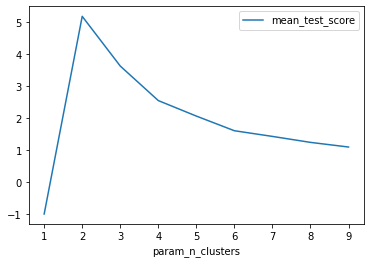

In [25]:
# Plot of scoring vs clusters
data[["param_n_clusters", "mean_test_score"]].plot(kind='line', 
                                                    x='param_n_clusters', 
                                                    y='mean_test_score') # Plot Score vs clusters

In [161]:
# We will take n_clusters = 6 because as the elbow point
k = 6
kMeans = KMeans(init = "k-means++", n_clusters = k, n_init = 1)
kMeans.fit(X)
dfCord["Cluster"] = kMeans.labels_
dfCord.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1


In [160]:
# We plot the Neighborhoods
# Define the world map
world_map = folium.Map()
# Define the world map centered around the dataframe with a low zoom level
means = dfCord[["Latitude", "Longitude"]].mean()
world_map = folium.Map(location=[means[0], means[1]],
                       zoom_start=10,
                       tiles='Stamen Terrain')
colorMap = plt.cm.Dark2

# loop through the neighborhoods and add each to the map
for lat, lng, label, neighborhood in zip(dfCord.Latitude, dfCord.Longitude, dfCord.Cluster,dfCord.Neighborhood):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        popup= folium.Popup(neighborhood, parse_html=True, max_width=100),
        fill=True,
        color=colors.to_hex(colorMap(label/k)),
        fill_color=colors.to_hex(colorMap(label/k)),
        fill_opacity=0.6
    ).add_to(world_map)

world_map